In [1]:
# Torch Imports
import torch, torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

# PLiNIO imports
from plinio.methods import PIT, SuperNet
from plinio.methods.mps import MPS, MPSType, get_default_qinfo
from plinio.methods.supernet import SuperNetModule
from plinio.cost import params, ops, params_bit, ops_bit
from plinio.regularizers import DUCCIO

# Stats imports
# import pandas as pd
import matplotlib.pyplot as plt

# Utils imports
import utils
import os
from PIL import Image, UnidentifiedImageError
from copy import deepcopy as dc
from glob import glob

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Dataset and DataLoader

In [3]:
# Transforms: we need to upscale our images
transforms = T.Compose([T.Resize([224,224]), T.ToTensor()])

In [4]:
image_folders = glob('.\Datasets\\notMNIST_large\*')

# Image classes available
image_folders

['.\\Datasets\\notMNIST_large\\A',
 '.\\Datasets\\notMNIST_large\\B',
 '.\\Datasets\\notMNIST_large\\C',
 '.\\Datasets\\notMNIST_large\\D',
 '.\\Datasets\\notMNIST_large\\E',
 '.\\Datasets\\notMNIST_large\\F',
 '.\\Datasets\\notMNIST_large\\G',
 '.\\Datasets\\notMNIST_large\\H',
 '.\\Datasets\\notMNIST_large\\I',
 '.\\Datasets\\notMNIST_large\\J']

In [5]:
# Dictionary: class names to idx
NotMNIST_class_dict = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8,
    'J': 9
}

In [6]:
# Train/test split percentage
NUN_SAMPLES = 6999
TRAIN_IDX = 5999

train_samples, train_labels = [], []
test_samples, test_labels = [], []
for folder in sorted(image_folders):
    # Sample label
    label = folder.split('\\')[-1]

    image_paths = glob(f'{folder}/*')
    for i, img_path in enumerate(image_paths):
        if i > NUN_SAMPLES: break
        
        try:
            # Apply transforms to the image
            img = transforms(Image.open(img_path)).unsqueeze(0)

            # Append to train or test set
            if i <= TRAIN_IDX:
                train_samples.append(img)
                train_labels.append(NotMNIST_class_dict[label])
            else:
                test_samples.append(img)
                test_labels.append(NotMNIST_class_dict[label])
        except UnidentifiedImageError as e:
            # Corrupted image detected
            print(f'Corrupted image. Removing {img_path}...')
            os.remove(img_path)

train_samples = torch.cat(train_samples)
test_samples = torch.cat(test_samples)

In [7]:
class NotMNISTDataset(Dataset):
    def __init__(self, X, y, class_dict):
        super().__init__()
        self.X = X
        self.y = y
        self.class_to_idx = class_dict
        self.classes = list(self.class_to_idx.keys())

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 1. Training set
train_dataset = NotMNISTDataset(train_samples, train_labels, NotMNIST_class_dict)

# 2. Test set
test_dataset = NotMNISTDataset(test_samples, test_labels, NotMNIST_class_dict)

In [8]:
# Information about the dataset
random_sample = train_dataset[torch.randint(0, len(train_dataset), size=[1]).item()][0]
class_names = train_dataset.classes

print(f'#Training samples: {len(train_dataset)}')
print(f'#Test samples: {len(test_dataset)}')

print(f'\n#Classes: {len(class_names)}')
print(f'List of classes: {class_names}')

print(f'\nData shape: {random_sample.shape}')

#Training samples: 60000
#Test samples: 10000

#Classes: 10
List of classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

Data shape: torch.Size([1, 224, 224])


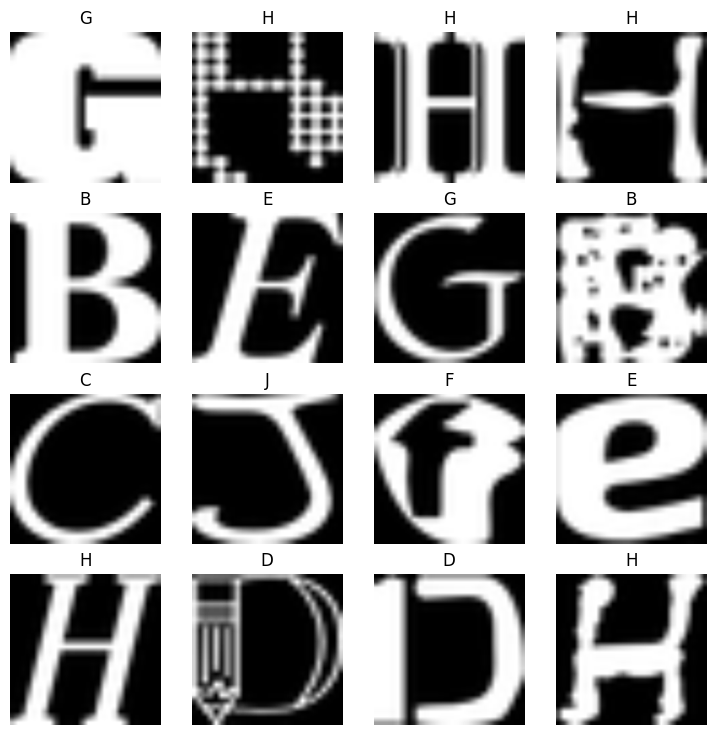

In [9]:
torch.manual_seed(42)
ROWS, COLS = 4, 4

# Data visualization
fig = plt.figure(figsize=[9, 9])
for i in range(1, ROWS*COLS+1):
    random_idx = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[random_idx]
    fig.add_subplot(ROWS, COLS, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [10]:
BATCH_SIZE = 16

# 1. Training data loader
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=0
)

# 2. Testing data loader
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=0
)

print(f'Created {len(train_dataloader)} training batches of {BATCH_SIZE} samples.')
print(f'Created {len(test_dataloader)} testing batches of {BATCH_SIZE} samples.')

Created 3750 training batches of 16 samples.
Created 625 testing batches of 16 samples.


# 2. VGG16 Model

In [11]:
torch.manual_seed(42)

# Load the PyTorch model
model = torchvision.models.vgg16()

# Model structure
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
# We are working with gray scale images
num_channels = train_dataset[0][0].shape[0]
print(f'#Channels of our images: {num_channels}')

#Channels of our images: 1


In [13]:
torch.manual_seed(42)

# We need to change the 1st convolutional layer
old_layer = model.features[0]
new_layer = nn.Conv2d(num_channels, 64, kernel_size=3, stride=1, padding=1)
model.features[0] = new_layer

print(f'Old layer: {old_layer}')
print(f'New layer: {new_layer}')

Old layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
New layer: Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [14]:
torch.manual_seed(42)

# We need to change the last fully connected layer to output 10 values
old_fc = model.classifier[-1]
new_fc = nn.Linear(in_features=4096, out_features=len(class_names))
model.classifier[-1] = new_fc

print(f'Old layer: {old_fc}')
print(f'New layer: {new_fc}')

Old layer: Linear(in_features=4096, out_features=1000, bias=True)
New layer: Linear(in_features=4096, out_features=10, bias=True)


In [15]:
# New model
model

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Save the model starting point for opitmization
torch.save(model, './Models_checkpoints/notMNIST/VGG16_notMNIST_Init.pth')

# 3. Traning loops

## 3.1 Model without optimization

In [17]:
# Setup optimizer and loss function
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [18]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the standard model
NoOpt_results = utils.train_model(
    model=model,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer
)

print(f"Total training time (on {NoOpt_results['device']}): {NoOpt_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {NoOpt_results['device']}): {(NoOpt_results['total_time']//3)} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 2.13749 | Avg Accuracy: 23.41%
Computed 999/3750 batches - Avg Loss: 1.57429 | Avg Accuracy: 46.99%
Computed 1499/3750 batches - Avg Loss: 1.30635 | Avg Accuracy: 57.44%
Computed 1999/3750 batches - Avg Loss: 1.14973 | Avg Accuracy: 63.26%
Computed 2499/3750 batches - Avg Loss: 1.04856 | Avg Accuracy: 66.96%
Computed 2999/3750 batches - Avg Loss: 0.97117 | Avg Accuracy: 69.66%
Computed 3499/3750 batches - Avg Loss: 0.91246 | Avg Accuracy: 71.74%

End of EPOCH 0 - Avg Loss: 0.88750 | Avg Accuracy: 72.57%
Training time: 661.472 seconds.
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.52610 | Avg Accuracy: 85.33%
Computed 999/3750 batches - Avg Loss: 0.51625 | Avg Accuracy: 85.56%
Computed 1499/3750 batches - Avg Loss: 0.50345 | Avg Accuracy: 85.82%
Computed 1999/3750 batches - Avg Loss: 0.49832 | Avg Accuracy: 85.86%
Computed 2499/3750 batches - Avg Loss: 0.49223 | Avg Accuracy: 85.95%
Computed 2999/3750 batches - Avg Loss: 0.48767 | Avg Accuracy: 86.07%
Computed 3499/3750 batches - Avg Loss: 0.48055 | Avg Accuracy: 86.25%

End of EPOCH 1 - Avg Loss: 0.47731 | Avg Accuracy: 86.28%
Training time: 657.133 seconds.
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.42629 | Avg Accuracy: 87.83%
Computed 999/3750 batches - Avg Loss: 0.42261 | Avg Accuracy: 87.78%
Computed 1499/3750 batches - Avg Loss: 0.42439 | Avg Accuracy: 87.75%
Computed 1999/3750 batches - Avg Loss: 0.42045 | Avg Accuracy: 87.82%
Computed 2499/3750 batches - Avg Loss: 0.41687 | Avg Accuracy: 87.93%
Computed 2999/3750 batches - Avg Loss: 0.41344 | Avg Accuracy: 88.07%
Computed 3499/3750 batches - Avg Loss: 0.41032 | Avg Accuracy: 88.10%

End of EPOCH 2 - Avg Loss: 0.40932 | Avg Accuracy: 88.14%
Training time: 654.214 seconds.
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.37277 | Avg Accuracy: 89.09%
Computed 999/3750 batches - Avg Loss: 0.37699 | Avg Accuracy: 88.95%
Computed 1499/3750 batches - Avg Loss: 0.36821 | Avg Accuracy: 89.23%
Computed 1999/3750 batches - Avg Loss: 0.36667 | Avg Accuracy: 89.29%
Computed 2499/3750 batches - Avg Loss: 0.36596 | Avg Accuracy: 89.31%
Computed 2999/3750 batches - Avg Loss: 0.36481 | Avg Accuracy: 89.35%
Computed 3499/3750 batches - Avg Loss: 0.36575 | Avg Accuracy: 89.29%

End of EPOCH 3 - Avg Loss: 0.36617 | Avg Accuracy: 89.24%
Training time: 653.399 seconds.
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.34185 | Avg Accuracy: 90.19%
Computed 999/3750 batches - Avg Loss: 0.34221 | Avg Accuracy: 90.02%
Computed 1499/3750 batches - Avg Loss: 0.34039 | Avg Accuracy: 90.01%
Computed 1999/3750 batches - Avg Loss: 0.34743 | Avg Accuracy: 89.78%
Computed 2499/3750 batches - Avg Loss: 0.34431 | Avg Accuracy: 89.89%
Computed 2999/3750 batches - Avg Loss: 0.34513 | Avg Accuracy: 89.83%
Computed 3499/3750 batches - Avg Loss: 0.34263 | Avg Accuracy: 89.88%

End of EPOCH 4 - Avg Loss: 0.34143 | Avg Accuracy: 89.91%
Training time: 656.096 seconds.
********************

Total training time (on cuda): 3282.313 seconds.
Avg training time (on cuda): 1094.0 seconds.


In [19]:
# Save the trained model weights as checkpoint
torch.save(model, './Models_checkpoints/notMNIST/VGG16_notMNIST_NoOpt.pth')

## 3.2 Models with optimization

In the following sections, the standard training loop will be modified with **PLiNIO** cost specifications, depending on the applied optimization method.

### 3.2.1 Pruning In Time (**PIT**)

In [20]:
# Load VGG16 initialization
PIT_init = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_Init.pth')

# Create PIT PLiNIO model object with parameters cost
PIT_model = PIT(model=PIT_init, input_shape=torch.Size([1,224,244]), cost={'size': params})
initial_size = PIT_model.get_cost('size').item()

print(f'#Parameters before PIT optimization: {int(initial_size)}')

#Parameters before PIT optimization: 134300368


In [21]:
# Setup loss_fn and regularizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=PIT_model.parameters(), lr=0.001)

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with PIT optimization
PIT_results = utils.train_model(
    model=PIT_model,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    optim_method='PIT',
    cost_strength={'size': 1e-6}
)

print(f"Total training time (on {PIT_results['device']}): {PIT_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {PIT_results['device']}): {(PIT_results['total_time']//3)} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 130.48083 | Avg Accuracy: 23.27%
Computed 999/3750 batches - Avg Loss: 123.75104 | Avg Accuracy: 46.94%
Computed 1499/3750 batches - Avg Loss: 117.57865 | Avg Accuracy: 57.42%
Computed 1999/3750 batches - Avg Loss: 111.70215 | Avg Accuracy: 63.27%
Computed 2499/3750 batches - Avg Loss: 106.03816 | Avg Accuracy: 66.99%
Computed 2999/3750 batches - Avg Loss: 100.66087 | Avg Accuracy: 65.48%
Computed 3499/3750 batches - Avg Loss: 95.32305 | Avg Accuracy: 67.37%

End of EPOCH 0 - Avg Loss: 92.67039 | Avg Accuracy: 68.27%
Training time: 706.049 seconds.

#Parameters after EPOCH 0: 52815968
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 48.80189 | Avg Accuracy: 81.79%
Computed 999/3750 batches - Avg Loss: 44.02430 | Avg Accuracy: 82.53%
Computed 1499/3750 batches - Avg Loss: 39.39478 | Avg Accuracy: 82.94%
Computed 1999/3750 batches - Avg Loss: 36.33380 | Avg Accuracy: 83.26%
Computed 2499/3750 batches - Avg Loss: 34.46345 | Avg Accuracy: 83.49%
Computed 2999/3750 batches - Avg Loss: 33.19204 | Avg Accuracy: 83.66%
Computed 3499/3750 batches - Avg Loss: 32.25745 | Avg Accuracy: 83.90%

End of EPOCH 1 - Avg Loss: 31.86867 | Avg Accuracy: 83.97%
Training time: 699.089 seconds.

#Parameters after EPOCH 1: 26009234
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 26.48100 | Avg Accuracy: 86.15%
Computed 999/3750 batches - Avg Loss: 26.37735 | Avg Accuracy: 86.09%
Computed 1499/3750 batches - Avg Loss: 26.29919 | Avg Accuracy: 85.89%
Computed 1999/3750 batches - Avg Loss: 26.21752 | Avg Accuracy: 85.94%
Computed 2499/3750 batches - Avg Loss: 26.14141 | Avg Accuracy: 86.01%
Computed 2999/3750 batches - Avg Loss: 26.06389 | Avg Accuracy: 86.09%
Computed 3499/3750 batches - Avg Loss: 25.98878 | Avg Accuracy: 86.15%

End of EPOCH 2 - Avg Loss: 25.94502 | Avg Accuracy: 86.18%
Training time: 708.490 seconds.

#Parameters after EPOCH 2: 24946582
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 25.36404 | Avg Accuracy: 87.55%
Computed 999/3750 batches - Avg Loss: 25.27253 | Avg Accuracy: 87.27%
Computed 1499/3750 batches - Avg Loss: 25.18750 | Avg Accuracy: 87.42%
Computed 1999/3750 batches - Avg Loss: 25.11445 | Avg Accuracy: 87.43%
Computed 2499/3750 batches - Avg Loss: 25.04177 | Avg Accuracy: 87.40%
Computed 2999/3750 batches - Avg Loss: 24.97178 | Avg Accuracy: 87.49%
Computed 3499/3750 batches - Avg Loss: 24.90435 | Avg Accuracy: 87.42%

End of EPOCH 3 - Avg Loss: 24.86340 | Avg Accuracy: 87.43%
Training time: 700.424 seconds.

#Parameters after EPOCH 3: 23931902
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 24.31483 | Avg Accuracy: 87.99%
Computed 999/3750 batches - Avg Loss: 24.22974 | Avg Accuracy: 87.94%
Computed 1499/3750 batches - Avg Loss: 24.15654 | Avg Accuracy: 87.93%
Computed 1999/3750 batches - Avg Loss: 24.09252 | Avg Accuracy: 87.79%
Computed 2499/3750 batches - Avg Loss: 24.01827 | Avg Accuracy: 88.02%
Computed 2999/3750 batches - Avg Loss: 23.95157 | Avg Accuracy: 88.00%
Computed 3499/3750 batches - Avg Loss: 23.88245 | Avg Accuracy: 88.09%

End of EPOCH 4 - Avg Loss: 23.84244 | Avg Accuracy: 88.12%
Training time: 703.868 seconds.

#Parameters after EPOCH 4: 22963104
********************

Total training time (on cuda): 3517.921 seconds.
Avg training time (on cuda): 1172.0 seconds.


In [23]:
# Check the results of optimization
optim_size = PIT_model.get_cost('size')
print(f'#Parameters went from {int(initial_size)} to {int(optim_size)} -> {((1 - (optim_size/initial_size))*100):.2f}% fewer parameters.')

#Parameters went from 134300368 to 22963102 -> 82.90% fewer parameters.


In [24]:
# Convert the model to PyTorch vanilla and save it
PIT_exported = PIT_model.export()
torch.save(PIT_exported, './Models_checkpoints/notMNIST/VGG16_notMNIST_PIT.pth')

### 3.2.2 Cost-aware Pruning In Time (PIT with **DUCCIO** regularizer)
*DUCCIO* regularizer is a feature of PLiNIO that allows to both eaily deal with multi-constraint optimization and treat cost metrics as constraints rather than just secondary objectives. The latter trait allows the regularizer to penalize the loss, whenever those constraints are exceeded, forcing the optimization to search only in a restricted space of the possible networks.

In the following example of application, we focus as before on the number of parameters in addition to the number of **FLOPS** (_floating point operations_), trying to look for a model, which uses <u>only 10%</u> both of the original parameters and the original FLOPS.

In [25]:
# Load VGG16 initialization
PIT_duccio_init = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_Init.pth')

# Create PIT PLiNIO model object with parameters and FLOPS cost
PIT_duccio = PIT(model=PIT_duccio_init, input_shape=random_sample.shape, cost={'#Parameters': params, '#FLOPS': ops})
initial_params = PIT_duccio.get_cost('#Parameters').item()
initial_flops = PIT_duccio.get_cost('#FLOPS').item()

# Define the constraint for the regularizer - 10% of the original parameters and FLOPS
constraint_params = torch.tensor(initial_params*0.1, device=device)
constraint_flops = torch.tensor(initial_flops*0.1, device=device)
params_strength = torch.tensor(1e-6, device=device)
flops_strength = torch.tensor(1e-9, device=device)

print(f'#Parameters before PIT optimization: {int(initial_params)}')
print(f'#FLOPS before PIT optimization: {int(initial_flops)}')

print(f'\nConstraint for DUCCIO regularizer (parameters): {int(constraint_params.item())} parameters.')
print(f'Constraint for DUCCIO regularizer (FLOPS): {int(constraint_flops.item())} parameters.')

# Create the regularizer
regularizer = DUCCIO({'#Parameters': constraint_params, '#FLOPS': constraint_flops}, final_strengths=(params_strength, flops_strength))

#Parameters before PIT optimization: 134300368
#FLOPS before PIT optimization: 15421962240

Constraint for DUCCIO regularizer (parameters): 13430037 parameters.
Constraint for DUCCIO regularizer (FLOPS): 1542196224 parameters.


In [26]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=PIT_duccio.parameters(), lr=0.001)

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with PIT optimization and DUCCIO regularizer
PIT_duccio_results = utils.train_model_duccio(
    model=PIT_duccio,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    cost_names=['#Parameters', '#FLOPS'],
    regularizer=regularizer
)

print(f"Total training time (on {PIT_duccio_results['device']}): {PIT_duccio_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {PIT_duccio_results['device']}): {(PIT_duccio_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 3.48618 | Avg Accuracy: 23.40%
Computed 999/3750 batches - Avg Loss: 2.92204 | Avg Accuracy: 47.05%
Computed 1499/3750 batches - Avg Loss: 2.65249 | Avg Accuracy: 57.53%
Computed 1999/3750 batches - Avg Loss: 2.49483 | Avg Accuracy: 63.38%
Computed 2499/3750 batches - Avg Loss: 2.39304 | Avg Accuracy: 66.99%
Computed 2999/3750 batches - Avg Loss: 2.31501 | Avg Accuracy: 69.69%
Computed 3499/3750 batches - Avg Loss: 2.25564 | Avg Accuracy: 71.75%

End of EPOCH 0 - Avg Loss: 2.23000 | Avg Accuracy: 72.56%
Training time: 873.980 seconds.

#Parameters after epoch EPOCH 0: 133358152
#FLOPS after epoch EPOCH 0: 15404723200
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 53.87745 | Avg Accuracy: 85.32%
Computed 999/3750 batches - Avg Loss: 52.75425 | Avg Accuracy: 85.56%
Computed 1499/3750 batches - Avg Loss: 51.67608 | Avg Accuracy: 85.77%
Computed 1999/3750 batches - Avg Loss: 50.62680 | Avg Accuracy: 85.91%
Computed 2499/3750 batches - Avg Loss: 49.59350 | Avg Accuracy: 86.00%
Computed 2999/3750 batches - Avg Loss: 48.57458 | Avg Accuracy: 86.17%
Computed 3499/3750 batches - Avg Loss: 47.56670 | Avg Accuracy: 86.32%

End of EPOCH 1 - Avg Loss: 47.05493 | Avg Accuracy: 86.32%
Training time: 877.379 seconds.

#Parameters after epoch EPOCH 1: 97132808
#FLOPS after epoch EPOCH 1: 14324458496
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 74.30938 | Avg Accuracy: 88.03%
Computed 999/3750 batches - Avg Loss: 70.64259 | Avg Accuracy: 87.88%
Computed 1499/3750 batches - Avg Loss: 67.25655 | Avg Accuracy: 83.08%
Computed 1999/3750 batches - Avg Loss: 63.86081 | Avg Accuracy: 81.83%
Computed 2499/3750 batches - Avg Loss: 60.49086 | Avg Accuracy: 81.56%
Computed 2999/3750 batches - Avg Loss: 57.16310 | Avg Accuracy: 81.62%
Computed 3499/3750 batches - Avg Loss: 53.87771 | Avg Accuracy: 81.71%

End of EPOCH 2 - Avg Loss: 52.23541 | Avg Accuracy: 81.79%
Training time: 823.701 seconds.

#Parameters after epoch EPOCH 2: 36606632
#FLOPS after epoch EPOCH 2: 12407147520
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 29.86375 | Avg Accuracy: 83.69%
Computed 999/3750 batches - Avg Loss: 26.82339 | Avg Accuracy: 83.80%
Computed 1499/3750 batches - Avg Loss: 25.60559 | Avg Accuracy: 84.33%
Computed 1999/3750 batches - Avg Loss: 24.88358 | Avg Accuracy: 84.44%
Computed 2499/3750 batches - Avg Loss: 24.35579 | Avg Accuracy: 84.76%
Computed 2999/3750 batches - Avg Loss: 23.92987 | Avg Accuracy: 85.02%
Computed 3499/3750 batches - Avg Loss: 23.56357 | Avg Accuracy: 85.12%

End of EPOCH 3 - Avg Loss: 23.38887 | Avg Accuracy: 85.14%
Training time: 822.913 seconds.

#Parameters after epoch EPOCH 3: 24792496
#FLOPS after epoch EPOCH 3: 10628842496
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 20.71484 | Avg Accuracy: 87.15%
Computed 999/3750 batches - Avg Loss: 20.48696 | Avg Accuracy: 86.90%
Computed 1499/3750 batches - Avg Loss: 20.26890 | Avg Accuracy: 86.92%
Computed 1999/3750 batches - Avg Loss: 20.06705 | Avg Accuracy: 86.84%
Computed 2499/3750 batches - Avg Loss: 19.85955 | Avg Accuracy: 87.06%
Computed 2999/3750 batches - Avg Loss: 19.66306 | Avg Accuracy: 87.07%
Computed 3499/3750 batches - Avg Loss: 19.46604 | Avg Accuracy: 87.20%

End of EPOCH 4 - Avg Loss: 19.36299 | Avg Accuracy: 87.28%
Training time: 822.986 seconds.

#Parameters after epoch EPOCH 4: 23329756
#FLOPS after epoch EPOCH 4: 9160346624
********************

Total training time (on cuda): 4220.959 seconds.
Avg training time (on cuda): 1406.986 seconds.


In [28]:
# Check the results of optimization
optim_params = PIT_duccio.get_cost('#Parameters').item()
optim_flops = PIT_duccio.get_cost('#FLOPS').item()

print(f'#Parameters went from {int(initial_params)} to {int(optim_params)} -> {((1 - (optim_params/initial_params))*100):.2f}% fewer parameters.')
print(f'#FLOPS went from {int(initial_flops)} to {int(optim_flops)} -> {((1 - (optim_flops/initial_flops))*100):.2f}% fewer FLOPS.')

#Parameters went from 134300368 to 23329758 -> 82.63% fewer parameters.
#FLOPS went from 15421962240 to 9160346624 -> 40.60% fewer FLOPS.


In [29]:
# Convert the model to PyTorch vanilla and save it
PIT_duccio_exported = PIT_duccio.export()
torch.save(PIT_duccio_exported, './Models_checkpoints/notMNIST/VGG16_notMNIST_PIT_duccio.pth')

### 3.2.3 Mixed-Precision Search (**MPS**)

In [30]:
# Load VGG16 initialization
MPS_init = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_Init.pth')

In [31]:
# Create the baseline model to retrieve the full model costs
model_baseline =  MPS(model=MPS_init,
                input_shape=random_sample.shape,
                qinfo=get_default_qinfo(
                    w_precision=(32,), # torch uses 32-bit floating point
                    a_precision=(32,)  # torch uses 32-bit floating point
                ),
                w_search_type=MPSType.PER_LAYER,
                cost={'size': params_bit, 'macs': ops_bit})

# Bits required for storing the model's weights
initial_storage = model_baseline.get_cost('size').item()
# BitOPS performed by the model
initial_bitops = model_baseline.get_cost('macs').item()

print(f"Storage required for weights: {(initial_storage/(8*1024**2)):.2f} MB - {int(initial_storage)} bits")
print(f"#BitOPS: {int(initial_bitops)}")

Storage required for weights: 512.27 MB - 4297213952 bits
#BitOPS: 15778208284672


In [32]:
# Create the PLiNIO model object with costs to optimize
MPS_model = MPS(model=MPS_init,
                input_shape=random_sample.shape,
                qinfo=get_default_qinfo(
                    w_precision=(8,16), # bit-widths to consider for weights
                    a_precision=(8,16)  # bit-widths to consider for activations
                ),
                w_search_type=MPSType.PER_LAYER,
                cost={'size': params_bit})

starting_storage = MPS_model.get_cost('size').item()

print(f"Starting storage required for weights: {(starting_storage/(8*1024**2)):.2f} MB - {int(starting_storage)} bits")

Starting storage required for weights: 207.78 MB - 1743013888 bits


In [33]:
# Initial precisions assigned to the layers 
MPS_model.summary()

{'x_input_quantizer': {'out_precision': 16, 'type': 'MPSIdentity'},
 'features.0': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.2': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.5': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.7': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.10': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.12': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.14': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.17': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.19': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSC

In [34]:
# Setup loss_fn and regularizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=MPS_model.parameters(), lr=0.001)

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with MPS optimization
MPS_results = utils.train_model(
    model=MPS_model,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    optim_method='MPS',
    cost_strength={'size': 1e-8}
)

print(f"Total training time (on {MPS_results['device']}): {MPS_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {MPS_results['device']}): {(MPS_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 17.68137 | Avg Accuracy: 22.09%
Computed 999/3750 batches - Avg Loss: 15.99202 | Avg Accuracy: 45.66%
Computed 1499/3750 batches - Avg Loss: 15.11719 | Avg Accuracy: 56.48%
Computed 1999/3750 batches - Avg Loss: 14.58126 | Avg Accuracy: 62.51%
Computed 2499/3750 batches - Avg Loss: 14.21458 | Avg Accuracy: 66.32%
Computed 2999/3750 batches - Avg Loss: 13.93555 | Avg Accuracy: 69.11%
Computed 3499/3750 batches - Avg Loss: 13.71859 | Avg Accuracy: 71.20%

End of EPOCH 0 - Avg Loss: 13.62284 | Avg Accuracy: 72.05%
Training time: 3632.052 seconds.

Storage required for weights: 140.34 MB - 1177226496 bits
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 12.29410 | Avg Accuracy: 85.10%
Computed 999/3750 batches - Avg Loss: 12.24466 | Avg Accuracy: 85.37%
Computed 1499/3750 batches - Avg Loss: 12.20242 | Avg Accuracy: 85.51%
Computed 1999/3750 batches - Avg Loss: 12.17256 | Avg Accuracy: 85.59%
Computed 2499/3750 batches - Avg Loss: 12.14433 | Avg Accuracy: 85.71%
Computed 2999/3750 batches - Avg Loss: 12.11880 | Avg Accuracy: 85.90%
Computed 3499/3750 batches - Avg Loss: 12.09328 | Avg Accuracy: 86.06%

End of EPOCH 1 - Avg Loss: 12.07829 | Avg Accuracy: 86.09%
Training time: 3829.821 seconds.

Storage required for weights: 136.76 MB - 1147193344 bits
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 11.91472 | Avg Accuracy: 87.84%
Computed 999/3750 batches - Avg Loss: 11.88456 | Avg Accuracy: 87.69%
Computed 1499/3750 batches - Avg Loss: 11.87132 | Avg Accuracy: 87.58%
Computed 1999/3750 batches - Avg Loss: 11.85390 | Avg Accuracy: 87.71%
Computed 2499/3750 batches - Avg Loss: 11.83965 | Avg Accuracy: 87.77%
Computed 2999/3750 batches - Avg Loss: 11.82589 | Avg Accuracy: 87.90%
Computed 3499/3750 batches - Avg Loss: 11.81262 | Avg Accuracy: 87.97%

End of EPOCH 2 - Avg Loss: 11.80366 | Avg Accuracy: 88.01%
Training time: 3920.307 seconds.

Storage required for weights: 135.00 MB - 1132489344 bits
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 11.71506 | Avg Accuracy: 88.89%
Computed 999/3750 batches - Avg Loss: 11.70069 | Avg Accuracy: 88.83%
Computed 1499/3750 batches - Avg Loss: 11.68057 | Avg Accuracy: 89.19%
Computed 1999/3750 batches - Avg Loss: 11.66985 | Avg Accuracy: 89.18%
Computed 2499/3750 batches - Avg Loss: 11.66087 | Avg Accuracy: 89.15%
Computed 2999/3750 batches - Avg Loss: 11.65247 | Avg Accuracy: 89.24%
Computed 3499/3750 batches - Avg Loss: 11.64596 | Avg Accuracy: 89.21%

End of EPOCH 3 - Avg Loss: 11.63948 | Avg Accuracy: 89.18%
Training time: 3935.103 seconds.

Storage required for weights: 133.80 MB - 1122355968 bits
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 11.58392 | Avg Accuracy: 89.95%
Computed 999/3750 batches - Avg Loss: 11.56458 | Avg Accuracy: 89.92%
Computed 1499/3750 batches - Avg Loss: 11.55559 | Avg Accuracy: 89.93%
Computed 1999/3750 batches - Avg Loss: 11.55472 | Avg Accuracy: 89.71%
Computed 2499/3750 batches - Avg Loss: 11.54550 | Avg Accuracy: 89.80%
Computed 2999/3750 batches - Avg Loss: 11.54078 | Avg Accuracy: 89.76%
Computed 3499/3750 batches - Avg Loss: 11.53267 | Avg Accuracy: 89.83%

End of EPOCH 4 - Avg Loss: 11.52599 | Avg Accuracy: 89.84%
Training time: 3860.083 seconds.

Storage required for weights: 132.90 MB - 1114853376 bits
********************

Total training time (on cuda): 19177.367 seconds.
Avg training time (on cuda): 6392.456 seconds.


In [36]:
optimized_storage = MPS_model.get_cost('size').item()

print(f'Storage required for weights after MPS: {(optimized_storage/(8*1024**2)):.2f} MB -> {((1 - (optimized_storage/initial_storage))*100):.2f}% less space required.')

Storage required for weights after MPS: 132.90 MB -> 74.06% less space required.


In [37]:
# Final precisions assigned to the layers
MPS_model.summary() 

{'x_input_quantizer': {'out_precision': 16, 'type': 'MPSIdentity'},
 'features.0': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.2': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.5': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.7': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.10': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.12': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.14': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 16,
  'type': 'MPSConv2d'},
 'features.17': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 8,
  'type': 'MPSConv2d'},
 'features.19': {'in_precision': 16,
  'out_precision': 16,
  'w_precision': 8,
  'type': 'MPSCon

In [38]:
# Convert the model to PyTorch vanilla
MPS_exported = MPS_model.export()

# Setup loss_fn and regularizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=MPS_exported.parameters(), lr=0.001)

# A couple of more epochs for fine-tuning
_ = utils.train_model(
    model=MPS_exported,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=2    
)

# Save the model
torch.save(MPS_exported, './Models_checkpoints/notMNIST/VGG16_notMNIST_MPS.pth')

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.33206 | Avg Accuracy: 90.18%
Computed 999/3750 batches - Avg Loss: 0.32765 | Avg Accuracy: 90.06%
Computed 1499/3750 batches - Avg Loss: 0.33001 | Avg Accuracy: 90.09%
Computed 1999/3750 batches - Avg Loss: 0.32699 | Avg Accuracy: 90.25%
Computed 2499/3750 batches - Avg Loss: 0.32561 | Avg Accuracy: 90.27%
Computed 2999/3750 batches - Avg Loss: 0.32417 | Avg Accuracy: 90.32%
Computed 3499/3750 batches - Avg Loss: 0.31921 | Avg Accuracy: 90.45%

End of EPOCH 0 - Avg Loss: 0.32144 | Avg Accuracy: 90.38%
Training time: 1274.715 seconds.
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.30265 | Avg Accuracy: 91.22%
Computed 999/3750 batches - Avg Loss: 0.30553 | Avg Accuracy: 90.92%
Computed 1499/3750 batches - Avg Loss: 0.30471 | Avg Accuracy: 90.90%
Computed 1999/3750 batches - Avg Loss: 0.30347 | Avg Accuracy: 90.91%
Computed 2499/3750 batches - Avg Loss: 0.30365 | Avg Accuracy: 90.85%
Computed 2999/3750 batches - Avg Loss: 0.30431 | Avg Accuracy: 90.83%
Computed 3499/3750 batches - Avg Loss: 0.30421 | Avg Accuracy: 90.80%

End of EPOCH 1 - Avg Loss: 0.30305 | Avg Accuracy: 90.82%
Training time: 1246.424 seconds.
********************



In [39]:
MPS_exported

VGG(
  (x_input_quantizer): QuantIdentity(
    (out_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
    tensor([1.0000], requires_grad=True), scale_factor=1.525908737676218e-05)
  )
  (features): Module(
    (0): QuantConv2d(
      1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (in_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
      tensor([1.0000], requires_grad=True), scale_factor=1.525908737676218e-05)
      (out_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
      tensor([6.], requires_grad=True), scale_factor=9.155413135886192e-05)
      (w_quantizer): MinMaxWeight(precision=16, scale_factor=tensor([9.8640e-06, 9.2526e-06, 8.0300e-06, 1.0050e-05, 9.7476e-06, 1.0070e-05,
              8.0587e-06, 9.0607e-06, 1.0080e-05, 7.6590e-06, 9.3059e-06, 9.8430e-06,
              1.0169e-05, 8.9510e-06, 8.8079e-06, 1.0316e-05, 9.2753e-06, 8.9916e-06,
              8.9649e-06, 9.5770e-06, 5.4544e-06, 8.7354e-06, 9.3221e-06, 

### 3.2.4 SuperNet

In [40]:
SuperNet_init = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_Init.pth')

# Initial structure
SuperNet_init

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In order to apply SuperNet optimization, we need to manually define alternatives for either single layers or enitre modules if the original structure. The alternatives you see down below have been tested, so that all of them do not compromise the training phase, meaning that the model should still learn.

VGG structure is mainly composed of two kinds of layers: **Convolutional** and **Linear**. Therefore the alternatives being considered are either special forms of these layers or the same layers with less parameters:
* for the _convolutional_ layers, since the `SuperNetModule` requires alternatives with the same output shape, we have selected specific convolutional layers of the VGG feature extractor, by considering either a **depth-wise** or a **point-wise** version of those layers;
* for the _linear_ layers, we have considered variations of the VGG classifier structure, by considering either the same number of layers with less parameters (hidden units) or a lower number of layers with less number of parameters (hidden units) 

In [41]:
# Original features structure
original_features = SuperNet_init.features

# 1st alternative - depth-wise convolution on layers increasing the number of channels
alt_1 = dc(original_features)
alt_1[5] = nn.Conv2d(original_features[5].in_channels, original_features[5].out_channels, original_features[5].kernel_size, stride=1, padding=original_features[5].padding, groups=original_features[5].in_channels)
alt_1[10] = nn.Conv2d(original_features[10].in_channels, original_features[10].out_channels, original_features[10].kernel_size, stride=1, padding=original_features[10].padding, groups=original_features[10].in_channels)
alt_1[17] = nn.Conv2d(original_features[17].in_channels, original_features[17].out_channels, original_features[17].kernel_size, stride=1, padding=original_features[17].padding, groups=original_features[17].in_channels)

# 2nd alternative - point-wise convolution on layers increasing the number of channels
alt_2 = dc(original_features)
alt_2[5] = nn.Conv2d(original_features[5].in_channels, original_features[5].out_channels, kernel_size=1 , stride=1)
alt_2[10] = nn.Conv2d(original_features[10].in_channels, original_features[10].out_channels,  kernel_size=1 , stride=1)
alt_2[17] = nn.Conv2d(original_features[17].in_channels, original_features[17].out_channels,  kernel_size=1 , stride=1)

# 3rd alternative - depth-wise convolution on the last 2 convolutional layers
alt_3 = dc(original_features)
alt_3[26] = nn.Conv2d(original_features[26].in_channels, original_features[26].out_channels, original_features[26].kernel_size, stride=1, padding=original_features[26].padding, groups=original_features[26].in_channels)
alt_3[28] = nn.Conv2d(original_features[28].in_channels, original_features[28].out_channels, original_features[28].kernel_size, stride=1, padding=original_features[28].padding, groups=original_features[28].in_channels)

In [42]:
# Original model's classifier structure
original_classifier = SuperNet_init.classifier

# 1st alternative
classifier_1 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=10, bias=True)
)

# 2nd alternative
classifier_2 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=10, bias=True)
)

# 3rd alternative
classifier_3 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=1024, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=10, bias=True)
)

In [43]:
# Modify the features structure for SuperNet optimization
SuperNet_init.features = SuperNetModule([
    original_features,
    alt_1,
    alt_2,
    alt_3
])

# Modify the classifer structure for SuperNet optimization
SuperNet_init.classifier = SuperNetModule([
    original_classifier,
    classifier_1,
    classifier_2,
    classifier_3
])

# New structure
SuperNet_init

VGG(
  (features): SuperNetModule(
    (sn_branches): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(

In [44]:
# Create PIT PLiNIO model object with parameters cost
SuperNet_model = SuperNet(SuperNet_init, input_shape=random_sample.shape, cost={'size': params})

initial_params = SuperNet_model.get_cost('size').item()
print(f"Parameters cost befor SuperNet optimization: {int(SuperNet_model.get_cost('size').item())}")

Parameters cost befor SuperNet optimization: 76264656


In [45]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(SuperNet_model.parameters(), lr=0.001)

In [46]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with SuperNet optimization
SuperNet_results = utils.train_model(
    model=SuperNet_model,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    optim_method='SuperNet',
    cost_strength={'size': 1e-7}
)

print(f"Total training time (on {SuperNet_results['device']}): {SuperNet_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {SuperNet_results['device']}): {(SuperNet_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 9.32876 | Avg Accuracy: 11.06%
Computed 999/3750 batches - Avg Loss: 8.85278 | Avg Accuracy: 11.82%
Computed 1499/3750 batches - Avg Loss: 8.46305 | Avg Accuracy: 13.51%
Computed 1999/3750 batches - Avg Loss: 7.98866 | Avg Accuracy: 22.73%
Computed 2499/3750 batches - Avg Loss: 7.48361 | Avg Accuracy: 33.43%
Computed 2999/3750 batches - Avg Loss: 7.08589 | Avg Accuracy: 41.21%
Computed 3499/3750 batches - Avg Loss: 6.77339 | Avg Accuracy: 47.07%

End of EPOCH 0 - Avg Loss: 6.63962 | Avg Accuracy: 49.48%
Training time: 5970.878 seconds.

#Parameters after EPOCH 0: 42029980
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.72539 | Avg Accuracy: 84.17%
Computed 999/3750 batches - Avg Loss: 4.68558 | Avg Accuracy: 84.47%
Computed 1499/3750 batches - Avg Loss: 4.64362 | Avg Accuracy: 84.80%
Computed 1999/3750 batches - Avg Loss: 4.61360 | Avg Accuracy: 85.16%
Computed 2499/3750 batches - Avg Loss: 4.58690 | Avg Accuracy: 85.33%
Computed 2999/3750 batches - Avg Loss: 4.56303 | Avg Accuracy: 85.55%
Computed 3499/3750 batches - Avg Loss: 4.53748 | Avg Accuracy: 85.85%

End of EPOCH 1 - Avg Loss: 4.52531 | Avg Accuracy: 85.93%
Training time: 6105.277 seconds.

#Parameters after EPOCH 1: 39418316
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.35246 | Avg Accuracy: 88.36%
Computed 999/3750 batches - Avg Loss: 4.33432 | Avg Accuracy: 88.28%
Computed 1499/3750 batches - Avg Loss: 4.32496 | Avg Accuracy: 88.19%
Computed 1999/3750 batches - Avg Loss: 4.31362 | Avg Accuracy: 88.22%
Computed 2499/3750 batches - Avg Loss: 4.30240 | Avg Accuracy: 88.33%
Computed 2999/3750 batches - Avg Loss: 4.29115 | Avg Accuracy: 88.48%
Computed 3499/3750 batches - Avg Loss: 4.28051 | Avg Accuracy: 88.57%

End of EPOCH 2 - Avg Loss: 4.27536 | Avg Accuracy: 88.57%
Training time: 6016.823 seconds.

#Parameters after EPOCH 2: 38353180
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.18765 | Avg Accuracy: 89.94%
Computed 999/3750 batches - Avg Loss: 4.18461 | Avg Accuracy: 89.81%
Computed 1499/3750 batches - Avg Loss: 4.17158 | Avg Accuracy: 89.86%
Computed 1999/3750 batches - Avg Loss: 4.16355 | Avg Accuracy: 89.90%
Computed 2499/3750 batches - Avg Loss: 4.15580 | Avg Accuracy: 89.96%
Computed 2999/3750 batches - Avg Loss: 4.15018 | Avg Accuracy: 89.98%
Computed 3499/3750 batches - Avg Loss: 4.14669 | Avg Accuracy: 89.93%

End of EPOCH 3 - Avg Loss: 4.14340 | Avg Accuracy: 89.89%
Training time: 5943.369 seconds.

#Parameters after EPOCH 3: 37661168
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.07625 | Avg Accuracy: 90.86%
Computed 999/3750 batches - Avg Loss: 4.06844 | Avg Accuracy: 90.92%
Computed 1499/3750 batches - Avg Loss: 4.06397 | Avg Accuracy: 90.83%
Computed 1999/3750 batches - Avg Loss: 4.06647 | Avg Accuracy: 90.65%
Computed 2499/3750 batches - Avg Loss: 4.06134 | Avg Accuracy: 90.68%
Computed 2999/3750 batches - Avg Loss: 4.05903 | Avg Accuracy: 90.66%
Computed 3499/3750 batches - Avg Loss: 4.05425 | Avg Accuracy: 90.73%

End of EPOCH 4 - Avg Loss: 4.05055 | Avg Accuracy: 90.75%
Training time: 6034.911 seconds.

#Parameters after EPOCH 4: 37195876
********************

Total training time (on cuda): 30071.258 seconds.
Avg training time (on cuda): 10023.753 seconds.


In [47]:
optim_params = SuperNet_model.get_cost('size')
print(f'#Parameters after SuperNet optimzation: {int(optim_params)} -> {((1 - optim_params/initial_params)*100):.2f}% fewer parameters.')

#Parameters after SuperNet optimzation: 37195876 -> 51.23% fewer parameters.


In [48]:
# Export the model to PyTorch vanilla and save it
SuperNet_exported = SuperNet_model.export()
torch.save(SuperNet_exported, './Models_checkpoints/notMNIST/VGG16_notMNIST_SuperNet.pth')

In [49]:
# Check the model structure assigned
SuperNet_exported

VGG(
  (features): Module(
    (sn_branches): Module(
      (3): Module(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

#### **LIMITATION**

In [50]:
# Results
SuperNet_model_results = utils.evaluate_model(model=SuperNet_exported, device=device, loss_fn=loss_fn, data_loader=train_dataloader)

print(f'''SuperNet optimization Results (on {SuperNet_model_results['device']}):
    - Total inference time: {SuperNet_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {SuperNet_model_results['avg_inference_time']:.3f} seconds
    - Minimum inference time: {SuperNet_model_results['min_inference_time']:.3f} seconds
    - Average loss: {SuperNet_model_results['avg_loss']:.5f}
    - Average accuracy: {(SuperNet_model_results['avg_acc']*100):.2f} %''')

SuperNet optimization Results (on cuda):
    - Total inference time: 20.920 seconds
    - Inference time per batch: 5.579 seconds
    - Minimum inference time: 3.205 seconds
    - Average loss: 2.30484
    - Average accuracy: 10.00 %


It looks like that the framework exports <u>only the architecture of the model</u>, rather the _trained_ model itself. Thus, further training is required!

In [51]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(SuperNet_exported.parameters(), lr=0.001)

In [52]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with SuperNet optimization
SuperNet_exported_results = utils.train_model(
    model=SuperNet_exported,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer
)

print(f"Total training time (on {SuperNet_exported_results['device']}): {SuperNet_exported_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {SuperNet_exported_results['device']}): {(SuperNet_exported_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 2.30808 | Avg Accuracy: 9.82%
Computed 999/3750 batches - Avg Loss: 2.30507 | Avg Accuracy: 9.97%
Computed 1499/3750 batches - Avg Loss: 2.30248 | Avg Accuracy: 10.82%
Computed 1999/3750 batches - Avg Loss: 2.21925 | Avg Accuracy: 16.39%
Computed 2499/3750 batches - Avg Loss: 1.98666 | Avg Accuracy: 26.94%
Computed 2999/3750 batches - Avg Loss: 1.79349 | Avg Accuracy: 35.09%
Computed 3499/3750 batches - Avg Loss: 1.63915 | Avg Accuracy: 41.42%

End of EPOCH 0 - Avg Loss: 1.57265 | Avg Accuracy: 44.11%
Training time: 638.275 seconds.
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.59353 | Avg Accuracy: 83.23%
Computed 999/3750 batches - Avg Loss: 0.57552 | Avg Accuracy: 83.67%
Computed 1499/3750 batches - Avg Loss: 0.54894 | Avg Accuracy: 84.25%
Computed 1999/3750 batches - Avg Loss: 0.53411 | Avg Accuracy: 84.62%
Computed 2499/3750 batches - Avg Loss: 0.52234 | Avg Accuracy: 84.93%
Computed 2999/3750 batches - Avg Loss: 0.51129 | Avg Accuracy: 85.23%
Computed 3499/3750 batches - Avg Loss: 0.49976 | Avg Accuracy: 85.52%

End of EPOCH 1 - Avg Loss: 0.49435 | Avg Accuracy: 85.63%
Training time: 633.615 seconds.
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.41218 | Avg Accuracy: 88.26%
Computed 999/3750 batches - Avg Loss: 0.40834 | Avg Accuracy: 88.09%
Computed 1499/3750 batches - Avg Loss: 0.40871 | Avg Accuracy: 88.08%
Computed 1999/3750 batches - Avg Loss: 0.40248 | Avg Accuracy: 88.13%
Computed 2499/3750 batches - Avg Loss: 0.39983 | Avg Accuracy: 88.25%
Computed 2999/3750 batches - Avg Loss: 0.39548 | Avg Accuracy: 88.42%
Computed 3499/3750 batches - Avg Loss: 0.39190 | Avg Accuracy: 88.48%

End of EPOCH 2 - Avg Loss: 0.39134 | Avg Accuracy: 88.48%
Training time: 625.345 seconds.
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.35410 | Avg Accuracy: 89.55%
Computed 999/3750 batches - Avg Loss: 0.36009 | Avg Accuracy: 89.34%
Computed 1499/3750 batches - Avg Loss: 0.35274 | Avg Accuracy: 89.53%
Computed 1999/3750 batches - Avg Loss: 0.35071 | Avg Accuracy: 89.64%
Computed 2499/3750 batches - Avg Loss: 0.34933 | Avg Accuracy: 89.71%
Computed 2999/3750 batches - Avg Loss: 0.34876 | Avg Accuracy: 89.75%
Computed 3499/3750 batches - Avg Loss: 0.35009 | Avg Accuracy: 89.72%

End of EPOCH 3 - Avg Loss: 0.34992 | Avg Accuracy: 89.66%
Training time: 620.359 seconds.
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.31865 | Avg Accuracy: 90.71%
Computed 999/3750 batches - Avg Loss: 0.32041 | Avg Accuracy: 90.50%
Computed 1499/3750 batches - Avg Loss: 0.32040 | Avg Accuracy: 90.44%
Computed 1999/3750 batches - Avg Loss: 0.32613 | Avg Accuracy: 90.26%
Computed 2499/3750 batches - Avg Loss: 0.32349 | Avg Accuracy: 90.30%
Computed 2999/3750 batches - Avg Loss: 0.32384 | Avg Accuracy: 90.34%
Computed 3499/3750 batches - Avg Loss: 0.32139 | Avg Accuracy: 90.37%

End of EPOCH 4 - Avg Loss: 0.31972 | Avg Accuracy: 90.41%
Training time: 636.141 seconds.
********************

Total training time (on cuda): 3153.735 seconds.
Avg training time (on cuda): 1051.245 seconds.


In [53]:
# Save the actually trained model
torch.save(SuperNet_exported, './Models_checkpoints/notMNIST/VGG16_notMNIST_SuperNet.pth')

### 3.2.5 Cost-aware SuperNet optimization (with **DUCCIO** regularizer)

As for cost-aware PIT, we now want to consider costs as constraints rather than just secondary objectives.

In order to do so we apply the SuperNet optimization, on the same modified model we used for standard SuperNet, adding the constraint of FLOPS to the list of costs. As before, the regularizer will be created in order to search in the space of networks which have <u>only 10%</u> pf the original parameters and FLOPS. 

In [54]:
# Load VGG16 initialization
SuperNet_init = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_Init.pth')

# Initial structure
SuperNet_init 

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [55]:
# Original features structure
original_features = SuperNet_init.features

# 1st alternative - depth-wise convolution on layers increasing the number of channels
alt_1 = dc(original_features)
alt_1[5] = nn.Conv2d(original_features[5].in_channels, original_features[5].out_channels, original_features[5].kernel_size, stride=1, padding=original_features[5].padding, groups=original_features[5].in_channels)
alt_1[10] = nn.Conv2d(original_features[10].in_channels, original_features[10].out_channels, original_features[10].kernel_size, stride=1, padding=original_features[10].padding, groups=original_features[10].in_channels)
alt_1[17] = nn.Conv2d(original_features[17].in_channels, original_features[17].out_channels, original_features[17].kernel_size, stride=1, padding=original_features[17].padding, groups=original_features[17].in_channels)

# 2nd alternative - point-wise convolution on layers increasing the number of channels
alt_2 = dc(original_features)
alt_2[5] = nn.Conv2d(original_features[5].in_channels, original_features[5].out_channels, kernel_size=1 , stride=1)
alt_2[10] = nn.Conv2d(original_features[10].in_channels, original_features[10].out_channels,  kernel_size=1 , stride=1)
alt_2[17] = nn.Conv2d(original_features[17].in_channels, original_features[17].out_channels,  kernel_size=1 , stride=1)

# 3rd alternative - depth-wise convolution on the last 2 convolutional layers
alt_3 = dc(original_features)
alt_3[26] = nn.Conv2d(original_features[26].in_channels, original_features[26].out_channels, original_features[26].kernel_size, stride=1, padding=original_features[26].padding, groups=original_features[26].in_channels)
alt_3[28] = nn.Conv2d(original_features[28].in_channels, original_features[28].out_channels, original_features[28].kernel_size, stride=1, padding=original_features[28].padding, groups=original_features[28].in_channels)

In [56]:
# Original model's classifier structure
original_classifier = SuperNet_init.classifier

# 1st alternative
classifier_1 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=10, bias=True)
)

# 2nd alternative
classifier_2 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=10, bias=True)
)

# 3rd alternative
classifier_3 = nn.Sequential(
    nn.Linear(in_features=25088, out_features=1024, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=1024, out_features=10, bias=True)
)

In [57]:
# Modify the features structure for SuperNet optimization
SuperNet_init.features = SuperNetModule([
    original_features,
    alt_1,
    alt_2,
    alt_3
])

# Modify the classifer structure for SuperNet optimization
SuperNet_init.classifier = SuperNetModule([
    original_classifier,
    classifier_1,
    classifier_2,
    classifier_3
])

# New structure
SuperNet_init

VGG(
  (features): SuperNetModule(
    (sn_branches): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(

In [58]:
# Create SuperNet PLiNIO model object with parameters and FLOPS cost
SuperNet_duccio = SuperNet(model=SuperNet_init, input_shape=random_sample.shape, cost={'#Parameters': params, '#FLOPS': ops})
initial_params = SuperNet_duccio.get_cost('#Parameters').item()
initial_flops = SuperNet_duccio.get_cost('#FLOPS').item()

# Define the constraint for the regularizer - 10% of the original parameters and FLOPS
constraint_params = torch.tensor(initial_params*0.1, device=device)
constraint_flops = torch.tensor(initial_flops*0.1, device=device)
params_strength = torch.tensor(1e-7, device=device)
flops_strength = torch.tensor(1e-10, device=device)

print(f'#Parameters before SuperNet optimization: {int(initial_params)}')
print(f'#FLOPS before SuperNet optimization: {int(initial_flops)}')

print(f'\nConstraint for DUCCIO regularizer (parameters): {int(constraint_params.item())} parameters.')
print(f'Constraint for DUCCIO regularizer (FLOPS): {int(constraint_flops.item())} parameters.')

# Create the regularizer
regularizer = DUCCIO({'#Parameters': constraint_params, '#FLOPS': constraint_flops}, final_strengths=(params_strength, flops_strength))

#Parameters before SuperNet optimization: 76264656
#FLOPS before SuperNet optimization: 14518124544

Constraint for DUCCIO regularizer (parameters): 7626465 parameters.
Constraint for DUCCIO regularizer (FLOPS): 1451812480 parameters.


In [59]:
# Setup loss function ad optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(SuperNet_duccio.parameters(), lr=0.001)

In [60]:
torch.cuda.empty_cache()

In [61]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with SuperNet optimization and DUCCIO regularizer
SuperNet_duccio_results = utils.train_model_duccio(
    model=SuperNet_duccio,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    cost_names=['#Parameters', '#FLOPS'],
    regularizer=regularizer
)

print(f"Total training time (on {SuperNet_duccio_results['device']}): {SuperNet_duccio_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {SuperNet_duccio_results['device']}): {(SuperNet_duccio_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 2.38823 | Avg Accuracy: 10.83%
Computed 999/3750 batches - Avg Loss: 2.38512 | Avg Accuracy: 10.69%
Computed 1499/3750 batches - Avg Loss: 2.38293 | Avg Accuracy: 11.14%
Computed 1999/3750 batches - Avg Loss: 2.37941 | Avg Accuracy: 12.18%
Computed 2499/3750 batches - Avg Loss: 2.29306 | Avg Accuracy: 18.21%
Computed 2999/3750 batches - Avg Loss: 2.07479 | Avg Accuracy: 27.53%
Computed 3499/3750 batches - Avg Loss: 1.89444 | Avg Accuracy: 34.98%

End of EPOCH 0 - Avg Loss: 1.81816 | Avg Accuracy: 38.08%
Training time: 6414.842 seconds.

#Parameters after epoch EPOCH 0: 74274736
#FLOPS after epoch EPOCH 0: 14532871168
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 3.77661 | Avg Accuracy: 82.38%
Computed 999/3750 batches - Avg Loss: 3.66078 | Avg Accuracy: 82.80%
Computed 1499/3750 batches - Avg Loss: 3.55462 | Avg Accuracy: 83.24%
Computed 1999/3750 batches - Avg Loss: 3.46424 | Avg Accuracy: 83.69%
Computed 2499/3750 batches - Avg Loss: 3.38234 | Avg Accuracy: 84.02%
Computed 2999/3750 batches - Avg Loss: 3.30842 | Avg Accuracy: 84.37%
Computed 3499/3750 batches - Avg Loss: 3.23705 | Avg Accuracy: 84.70%

End of EPOCH 1 - Avg Loss: 3.20383 | Avg Accuracy: 84.82%
Training time: 6292.153 seconds.

#Parameters after epoch EPOCH 1: 50713556
#FLOPS after epoch EPOCH 1: 14456420352
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.81632 | Avg Accuracy: 87.61%
Computed 999/3750 batches - Avg Loss: 4.70825 | Avg Accuracy: 87.58%
Computed 1499/3750 batches - Avg Loss: 4.62767 | Avg Accuracy: 87.51%
Computed 1999/3750 batches - Avg Loss: 4.55679 | Avg Accuracy: 87.49%
Computed 2499/3750 batches - Avg Loss: 4.49863 | Avg Accuracy: 87.64%
Computed 2999/3750 batches - Avg Loss: 4.44887 | Avg Accuracy: 87.82%
Computed 3499/3750 batches - Avg Loss: 4.40596 | Avg Accuracy: 87.93%

End of EPOCH 2 - Avg Loss: 4.38649 | Avg Accuracy: 87.98%
Training time: 6389.231 seconds.

#Parameters after epoch EPOCH 2: 41140032
#FLOPS after epoch EPOCH 2: 14348547072
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.99060 | Avg Accuracy: 89.68%
Computed 999/3750 batches - Avg Loss: 4.97498 | Avg Accuracy: 89.36%
Computed 1499/3750 batches - Avg Loss: 4.94758 | Avg Accuracy: 89.44%
Computed 1999/3750 batches - Avg Loss: 4.92864 | Avg Accuracy: 89.44%
Computed 2499/3750 batches - Avg Loss: 4.91077 | Avg Accuracy: 89.54%
Computed 2999/3750 batches - Avg Loss: 4.89691 | Avg Accuracy: 89.58%
Computed 3499/3750 batches - Avg Loss: 4.88583 | Avg Accuracy: 89.52%

End of EPOCH 3 - Avg Loss: 4.87832 | Avg Accuracy: 89.52%
Training time: 6206.707 seconds.

#Parameters after epoch EPOCH 3: 39180848
#FLOPS after epoch EPOCH 3: 14272978944
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 4.75617 | Avg Accuracy: 90.72%
Computed 999/3750 batches - Avg Loss: 4.74541 | Avg Accuracy: 90.57%
Computed 1499/3750 batches - Avg Loss: 4.73599 | Avg Accuracy: 90.57%
Computed 1999/3750 batches - Avg Loss: 4.73272 | Avg Accuracy: 90.48%
Computed 2499/3750 batches - Avg Loss: 4.72322 | Avg Accuracy: 90.53%
Computed 2999/3750 batches - Avg Loss: 4.71801 | Avg Accuracy: 90.51%
Computed 3499/3750 batches - Avg Loss: 4.71025 | Avg Accuracy: 90.55%

End of EPOCH 4 - Avg Loss: 4.70485 | Avg Accuracy: 90.55%
Training time: 6290.550 seconds.

#Parameters after epoch EPOCH 4: 38283812
#FLOPS after epoch EPOCH 4: 14250912768
********************

Total training time (on cuda): 31593.483 seconds.
Avg training time (on cuda): 10531.161 seconds.


In [62]:
# Check the results of optimization
optim_params = SuperNet_duccio.get_cost('#Parameters').item()
optim_flops = SuperNet_duccio.get_cost('#FLOPS').item()

print(f'#Parameters went from {int(initial_params)} to {int(optim_params)} -> {((1 - (optim_params/initial_params))*100):.2f}% fewer parameters.')
print(f'#FLOPS went from {int(initial_flops)} to {int(optim_flops)} -> {((1 - (optim_flops/initial_flops))*100):.2f}% fewer FLOPS.')

#Parameters went from 76264656 to 38283812 -> 49.80% fewer parameters.
#FLOPS went from 14518124544 to 14250912768 -> 1.84% fewer FLOPS.


In [63]:
# Convert the model to PyTorch vanilla and save it
SuperNet_duccio_exported = SuperNet_duccio.export()
torch.save(SuperNet_duccio_exported, './Models_checkpoints/notMNIST/VGG16_notMNIST_SuperNet_duccio.pth')

In [64]:
SuperNet_duccio_exported

VGG(
  (features): Module(
    (sn_branches): Module(
      (3): Module(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

#### **LIMITATION**

For the same reason as standard SuperNet, also in this case only the architecture is exported rather than the whole trained model. Thus, further training is required! 

In [65]:
# Setup loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(SuperNet_duccio_exported.parameters(), lr=0.001)

In [66]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train the model with SuperNet optimization
SuperNet_exported_results = utils.train_model(
    model=SuperNet_duccio_exported,
    data_loader=train_dataloader,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer
)

print(f"Total training time (on {SuperNet_exported_results['device']}): {SuperNet_exported_results['total_time']:.3f} seconds.")
print(f"Avg training time (on {SuperNet_exported_results['device']}): {(SuperNet_exported_results['total_time']/3):.3f} seconds.")

********************
EPOCH 0



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 2.30726 | Avg Accuracy: 9.68%
Computed 999/3750 batches - Avg Loss: 2.30452 | Avg Accuracy: 10.11%
Computed 1499/3750 batches - Avg Loss: 2.30335 | Avg Accuracy: 10.36%
Computed 1999/3750 batches - Avg Loss: 2.30239 | Avg Accuracy: 10.79%
Computed 2499/3750 batches - Avg Loss: 2.30110 | Avg Accuracy: 11.75%
Computed 2999/3750 batches - Avg Loss: 2.29538 | Avg Accuracy: 13.67%
Computed 3499/3750 batches - Avg Loss: 2.14441 | Avg Accuracy: 20.63%

End of EPOCH 0 - Avg Loss: 2.05720 | Avg Accuracy: 24.31%
Training time: 814.751 seconds.
********************

********************
EPOCH 1



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.71170 | Avg Accuracy: 80.52%
Computed 999/3750 batches - Avg Loss: 0.67000 | Avg Accuracy: 81.25%
Computed 1499/3750 batches - Avg Loss: 0.62805 | Avg Accuracy: 82.17%
Computed 1999/3750 batches - Avg Loss: 0.60117 | Avg Accuracy: 82.75%
Computed 2499/3750 batches - Avg Loss: 0.57983 | Avg Accuracy: 83.24%
Computed 2999/3750 batches - Avg Loss: 0.56245 | Avg Accuracy: 83.79%
Computed 3499/3750 batches - Avg Loss: 0.54501 | Avg Accuracy: 84.24%

End of EPOCH 1 - Avg Loss: 0.53754 | Avg Accuracy: 84.41%
Training time: 696.249 seconds.
********************

********************
EPOCH 2



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.41908 | Avg Accuracy: 88.01%
Computed 999/3750 batches - Avg Loss: 0.41514 | Avg Accuracy: 87.87%
Computed 1499/3750 batches - Avg Loss: 0.41546 | Avg Accuracy: 87.89%
Computed 1999/3750 batches - Avg Loss: 0.41070 | Avg Accuracy: 87.95%
Computed 2499/3750 batches - Avg Loss: 0.40764 | Avg Accuracy: 88.02%
Computed 2999/3750 batches - Avg Loss: 0.40351 | Avg Accuracy: 88.16%
Computed 3499/3750 batches - Avg Loss: 0.39949 | Avg Accuracy: 88.28%

End of EPOCH 2 - Avg Loss: 0.39873 | Avg Accuracy: 88.28%
Training time: 658.459 seconds.
********************

********************
EPOCH 3



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.35308 | Avg Accuracy: 89.45%
Computed 999/3750 batches - Avg Loss: 0.36090 | Avg Accuracy: 89.39%
Computed 1499/3750 batches - Avg Loss: 0.35390 | Avg Accuracy: 89.55%
Computed 1999/3750 batches - Avg Loss: 0.35124 | Avg Accuracy: 89.56%
Computed 2499/3750 batches - Avg Loss: 0.35033 | Avg Accuracy: 89.62%
Computed 2999/3750 batches - Avg Loss: 0.35019 | Avg Accuracy: 89.62%
Computed 3499/3750 batches - Avg Loss: 0.35080 | Avg Accuracy: 89.59%

End of EPOCH 3 - Avg Loss: 0.35112 | Avg Accuracy: 89.53%
Training time: 671.569 seconds.
********************

********************
EPOCH 4



  0%|          | 0/3750 [00:00<?, ?batch/s]

Computed 499/3750 batches - Avg Loss: 0.32573 | Avg Accuracy: 90.61%
Computed 999/3750 batches - Avg Loss: 0.32453 | Avg Accuracy: 90.35%
Computed 1499/3750 batches - Avg Loss: 0.32307 | Avg Accuracy: 90.30%
Computed 1999/3750 batches - Avg Loss: 0.32688 | Avg Accuracy: 90.21%
Computed 2499/3750 batches - Avg Loss: 0.32444 | Avg Accuracy: 90.26%
Computed 2999/3750 batches - Avg Loss: 0.32525 | Avg Accuracy: 90.27%
Computed 3499/3750 batches - Avg Loss: 0.32235 | Avg Accuracy: 90.34%

End of EPOCH 4 - Avg Loss: 0.32185 | Avg Accuracy: 90.34%
Training time: 672.943 seconds.
********************

Total training time (on cuda): 3513.970 seconds.
Avg training time (on cuda): 1171.323 seconds.


In [67]:
# Save the actually trained model
torch.save(SuperNet_duccio_exported, './Models_checkpoints/notMNIST/VGG16_notMNIST_SuperNet_duccio.pth')

# 4. Evaluation (models comparison)

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [69]:
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

## 4.1 Standard VGG16

In [70]:
# Model
standard_model = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_NoOpt.pth')

# Results
size_mb_baseline = utils.model_size(model=standard_model)
standard_model_results = utils.evaluate_model(model=standard_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

print(f'''Standard VGG16 Inference Results (on {standard_model_results['device']}):
    - Model size: {size_mb_baseline:.3f} MB
    - Total inference time: {standard_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {standard_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {standard_model_results['min_inference_time']:.3f} milliseconds
    - Average loss: {standard_model_results['avg_loss']:.5f}
    - Average accuracy: {(standard_model_results['avg_acc']*100):.2f}%''')

Standard VGG16 Inference Results (on cuda):
    - Model size: 512.315 MB
    - Total inference time: 3.350 seconds
    - Inference time per batch: 5.361 milliseconds
    - Minimum inference time: 3.111 milliseconds
    - Average loss: 0.30265
    - Average accuracy: 91.90%


## 4.2 VGG16 with PIT optimization

In [71]:
# Model
PIT_model = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_PIT.pth')

# Results
size_mb = utils.model_size(model=PIT_model)
PIT_model_results = utils.evaluate_model(model=PIT_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

# Compare the results with the standard model
size_ratio = size_mb / size_mb_baseline

print(f'''PIT optimization Results (on {PIT_model_results['device']}):
    - Model size: {size_mb:.3f} MB -> {((1 - size_ratio)*100):.2f}% lighter than baseline
    - Total inference time: {PIT_model_results['total_inference_time']:.3f} milliseconds
    - Inference time per batch: {PIT_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {PIT_model_results['min_inference_time']:.3f} seconds
    - Average loss: {PIT_model_results['avg_loss']:.5f}
    - Average accuracy: {(PIT_model_results['avg_acc']*100):.2f}%''')

PIT optimization Results (on cuda):
    - Model size: 112.096 MB -> 78.12% lighter than baseline
    - Total inference time: 3.585 milliseconds
    - Inference time per batch: 5.736 milliseconds
    - Minimum inference time: 3.219 seconds
    - Average loss: 0.32679
    - Average accuracy: 91.03%


In [72]:
PIT_model

GraphModule(
  (features): Module(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

## 4.3 VGG16 with PIT-DUCCIO optimization

In [73]:
# Model
PIT_duccio_model = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_PIT_duccio.pth')

# Results
size_mb = utils.model_size(model=PIT_duccio_model)
PIT_duccio_model_results = utils.evaluate_model(model=PIT_duccio_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

# Compare the results with the standard model
size_ratio = size_mb / size_mb_baseline

print(f'''PIT-DUCCIO optimization Results (on {PIT_duccio_model_results['device']}):
    - Model size: {size_mb:.3f} MB -> {((1 - size_ratio)*100):.2f}% lighter than baseline
    - Total inference time: {PIT_duccio_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {PIT_duccio_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {PIT_duccio_model_results['min_inference_time']:.3f} milliseconds
    - Average loss: {PIT_duccio_model_results['avg_loss']:.5f}
    - Average accuracy: {(PIT_duccio_model_results['avg_acc']*100):.2f} %''')

PIT-DUCCIO optimization Results (on cuda):
    - Model size: 112.096 MB -> 78.12% lighter than baseline
    - Total inference time: 3.514 seconds
    - Inference time per batch: 5.622 milliseconds
    - Minimum inference time: 3.621 milliseconds
    - Average loss: 0.32980
    - Average accuracy: 90.71 %


In [74]:
PIT_duccio_model

GraphModule(
  (features): Module(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

## 4.4 VGG16 with MPS optimization

In [75]:
# Model
MPS_model = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_MPS.pth')

# Results
size_mb = utils.model_size(model=MPS_model)
MPS_model_results = utils.evaluate_model(model=MPS_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

# Compare the results with the standard model
size_ratio = size_mb / size_mb_baseline

print(f'''MPS optimization Results (on {MPS_model_results['device']}):
    - Model size: {size_mb:.3f} MB -> {((1 - size_ratio)*100):.2f}% lighter than baseline
    - Total inference time: {MPS_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {MPS_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {MPS_model_results['min_inference_time']:.3f} milliseconds
    - Average loss: {MPS_model_results['avg_loss']:.5f}
    - Average accuracy: {(MPS_model_results['avg_acc']*100):.2f} %''')

MPS optimization Results (on cuda):
    - Model size: 512.315 MB -> -0.00% lighter than baseline
    - Total inference time: 89.227 seconds
    - Inference time per batch: 142.763 milliseconds
    - Minimum inference time: 138.362 milliseconds
    - Average loss: 0.29953
    - Average accuracy: 91.77 %


In [76]:
MPS_model

GraphModule(
  (x_input_quantizer): QuantIdentity(
    (out_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
    tensor([1.0000], requires_grad=True), scale_factor=1.525908737676218e-05)
  )
  (features): Module(
    (0): QuantConv2d(
      1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
      (in_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
      tensor([1.0000], requires_grad=True), scale_factor=1.525908737676218e-05)
      (out_quantizer): PACTAct(precision=16, clip_val=Parameter containing:
      tensor([6.], requires_grad=True), scale_factor=9.155413135886192e-05)
      (w_quantizer): MinMaxWeight(precision=16, scale_factor=tensor([9.8637e-06, 9.2523e-06, 8.0300e-06, 1.0050e-05, 9.7473e-06, 1.0070e-05,
              8.0587e-06, 9.0606e-06, 1.0080e-05, 7.6590e-06, 9.3060e-06, 9.8430e-06,
              1.0169e-05, 8.9510e-06, 8.8078e-06, 1.0316e-05, 9.2752e-06, 8.9917e-06,
              8.9649e-06, 9.5770e-06, 5.4544e-06, 8.7355e-06, 9.32

#### **LIMITATION**

The exported model does not come with changed data types according to the precisions found during MPS. Rather, it comes with quantizers (_e.g._ `in_quantizer`, `out_quantizer`, `w_quantizer`, `b_quantizer`) for each layer considered during optimization. That's why there is no gain in memory space (the size of the model is equal to the baseline) and the model takes much more time for inference. 

In [77]:
# Look at layers' datatypes
for name, param in MPS_model.named_parameters():
    print(f'Parameter: {name} -> Precision: {param.dtype}')

Parameter: x_input_quantizer.out_quantizer.clip_val -> Precision: torch.float32
Parameter: features.0.weight -> Precision: torch.float32
Parameter: features.0.bias -> Precision: torch.float32
Parameter: features.0.out_quantizer.clip_val -> Precision: torch.float32
Parameter: features.2.weight -> Precision: torch.float32
Parameter: features.2.bias -> Precision: torch.float32
Parameter: features.2.out_quantizer.clip_val -> Precision: torch.float32
Parameter: features.5.weight -> Precision: torch.float32
Parameter: features.5.bias -> Precision: torch.float32
Parameter: features.5.out_quantizer.clip_val -> Precision: torch.float32
Parameter: features.7.weight -> Precision: torch.float32
Parameter: features.7.bias -> Precision: torch.float32
Parameter: features.7.out_quantizer.clip_val -> Precision: torch.float32
Parameter: features.10.weight -> Precision: torch.float32
Parameter: features.10.bias -> Precision: torch.float32
Parameter: features.10.out_quantizer.clip_val -> Precision: torch.

## 4.5 VGG16 with SuperNet optimization

In [78]:
# Model
SuperNet_model = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_SuperNet.pth')

# Results
size_mb = utils.model_size(model=SuperNet_model)
SuperNet_model_results = utils.evaluate_model(model=SuperNet_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

# Compare the results with the standard model
size_ratio = size_mb / size_mb_baseline

print(f'''SuperNet optimization Results (on {SuperNet_model_results['device']}):
    - Model size: {size_mb:.3f} MB -> {((1 - size_ratio)*100):.2f}% lighter than baseline
    - Total inference time: {SuperNet_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {SuperNet_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {SuperNet_model_results['min_inference_time']:.3f} milliseconds
    - Average loss: {SuperNet_model_results['avg_loss']:.5f}
    - Average accuracy: {(SuperNet_model_results['avg_acc']*100):.2f} %''')

SuperNet optimization Results (on cuda):
    - Model size: 136.206 MB -> 73.41% lighter than baseline
    - Total inference time: 3.366 seconds
    - Inference time per batch: 5.385 milliseconds
    - Minimum inference time: 3.276 milliseconds
    - Average loss: 0.30037
    - Average accuracy: 91.97 %


In [79]:
SuperNet_model

GraphModule(
  (features): Module(
    (sn_branches): Module(
      (3): Module(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [80]:
# Model
SuperNet_duccio_model = torch.load('./Models_checkpoints/notMNIST/VGG16_notMNIST_SuperNet_duccio.pth')

# Results
size_mb = utils.model_size(model=SuperNet_duccio_model)
SuperNet_duccio_model_results = utils.evaluate_model(model=SuperNet_duccio_model, device=device, loss_fn=loss_fn, data_loader=test_dataloader)

# Compare the results with the standard model
size_ratio = size_mb / size_mb_baseline

print(f'''SuperNet optimization Results (on {SuperNet_duccio_model_results['device']}):
    - Model size: {size_mb:.3f} MB -> {((1 - size_ratio)*100):.2f}% lighter than baseline
    - Total inference time: {SuperNet_duccio_model_results['total_inference_time']:.3f} seconds
    - Inference time per batch: {SuperNet_duccio_model_results['avg_inference_time']:.3f} milliseconds
    - Minimum inference time: {SuperNet_duccio_model_results['min_inference_time']:.3f} milliseconds
    - Average loss: {SuperNet_duccio_model_results['avg_loss']:.5f}
    - Average accuracy: {(SuperNet_duccio_model_results['avg_acc']*100):.2f} %''')

SuperNet optimization Results (on cuda):
    - Model size: 136.206 MB -> 73.41% lighter than baseline
    - Total inference time: 3.287 seconds
    - Inference time per batch: 5.259 milliseconds
    - Minimum inference time: 3.464 milliseconds
    - Average loss: 0.29239
    - Average accuracy: 92.08 %


In [81]:
SuperNet_duccio_model

GraphModule(
  (features): Module(
    (sn_branches): Module(
      (3): Module(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p